# Explore here

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import shutil
import random
from collections import Counter
import pickle 

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

2025-11-21 17:24:25.052672: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 17:24:25.460709: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 17:24:59.581911: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 17:25:21.521673: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
data_path = '/workspaces/agumarquez----Proyecto-Tutorial-de-Clasficador-de-Imagenes/data/processed/train'
print("Ejemplos de archivos:", os.listdir(data_path)[:10])

Ejemplos de archivos: ['cat.10608.jpg', 'cat.469.jpg', 'dog.4305.jpg', 'dog.12149.jpg', 'dog.5207.jpg', 'dog.7895.jpg', 'cat.11989.jpg', 'cat.7293.jpg', 'dog.12447.jpg', 'dog.2632.jpg']


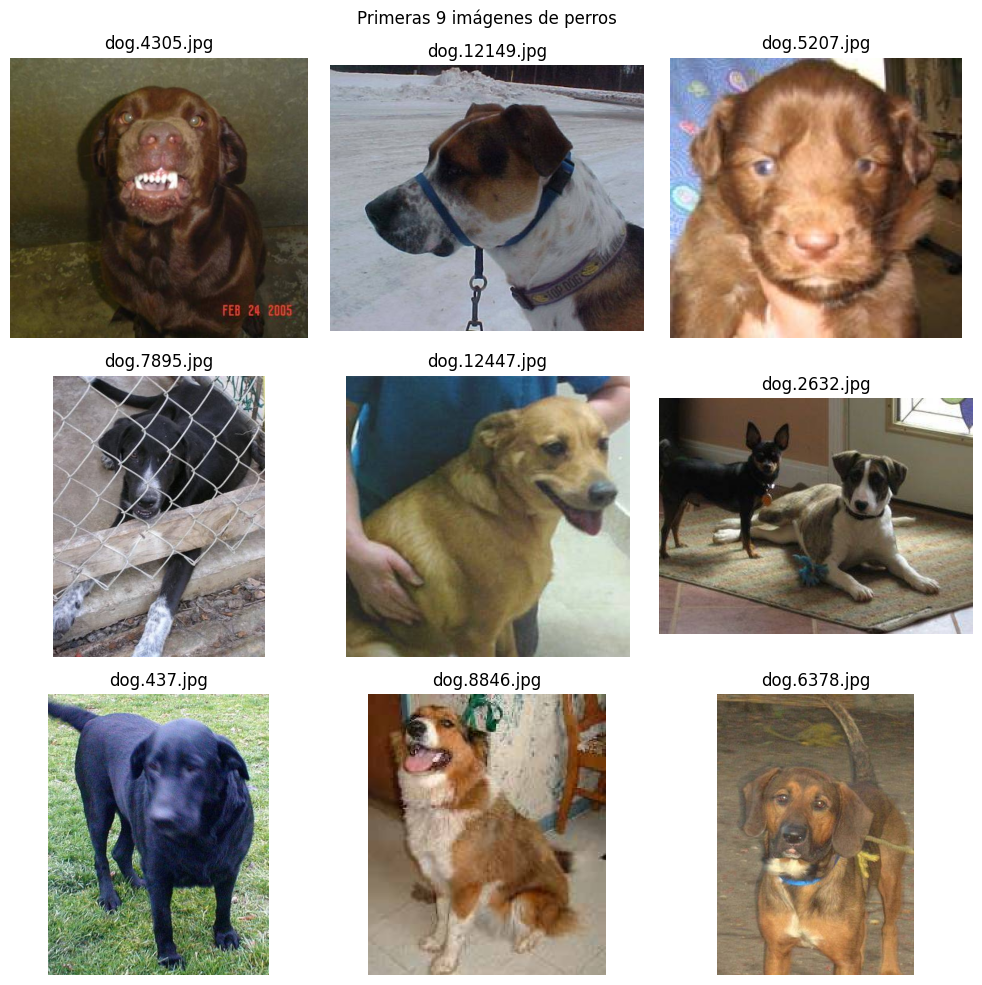

In [3]:
dog_images = [f for f in os.listdir(data_path) if f.startswith('dog')][:9]

plt.figure(figsize=(10, 10))
for i, img_name in enumerate(dog_images):
    img_path = os.path.join(data_path, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
plt.suptitle('Primeras 9 imágenes de perros')
plt.tight_layout()
plt.show()

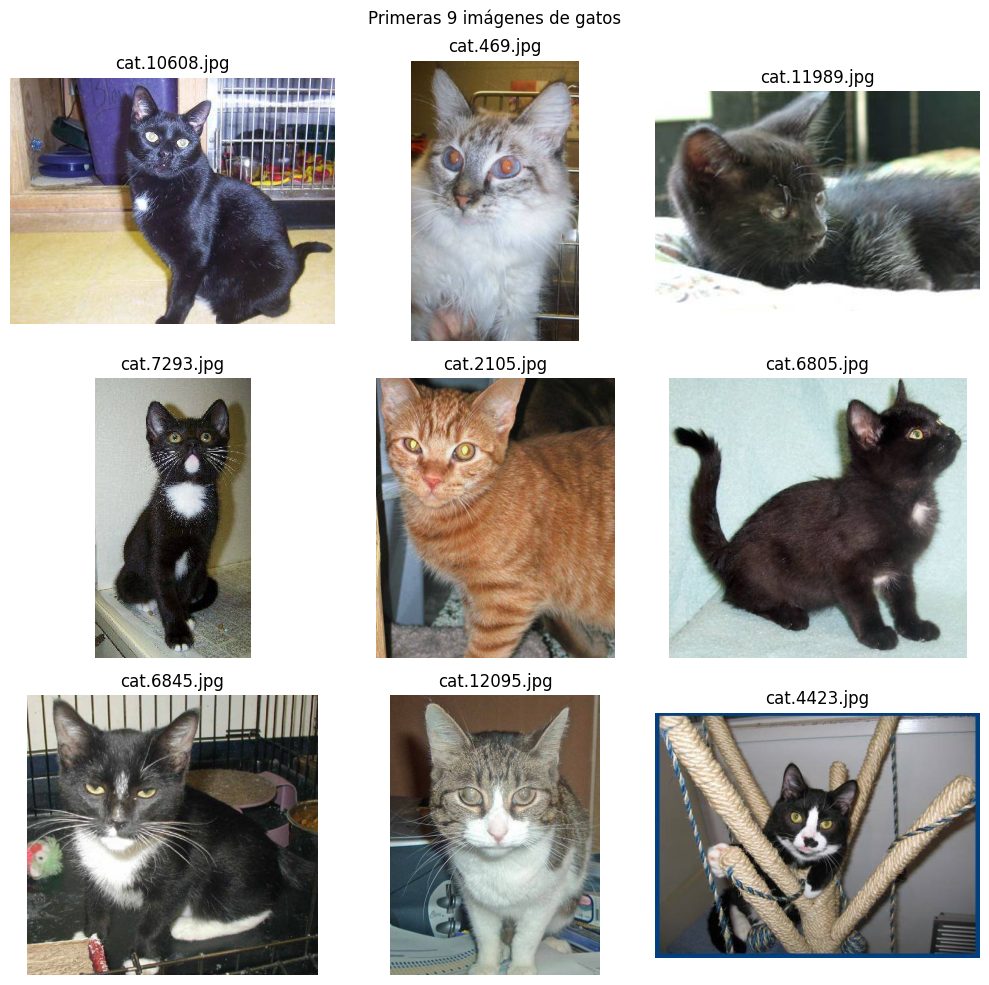

In [4]:
cat_images = [f for f in os.listdir(data_path) if f.startswith('cat')][:9]

plt.figure(figsize=(10, 10))
for i, img_name in enumerate(cat_images):
    img_path = os.path.join(data_path, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
plt.suptitle('Primeras 9 imágenes de gatos')
plt.tight_layout()
plt.show()

In [5]:
filenames = os.listdir(data_path)
labels = [0 if f.startswith("cat") else 1 for f in filenames]  # 0 = gato, 1 = perro

train_files, test_files, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.2, random_state=42, stratify=labels
)

print("Train:", len(train_files), "Test:", len(test_files))

Train: 20000 Test: 5000


In [6]:

# Ruta donde están los archivos mezclados
data_path = "/workspaces/agumarquez----Proyecto-Tutorial-de-Clasficador-de-Imagenes/data/processed/train"

# Carpeta raíz donde quieres guardar train/test
base_path = "/workspaces/agumarquez----Proyecto-Tutorial-de-Clasficador-de-Imagenes/data"

# Crear estructura de carpetas dentro de data/
for split in ["train", "test"]:
    for cls in ["cat", "dog"]:
        os.makedirs(os.path.join(base_path, split, cls), exist_ok=True)

# Listar imágenes
all_images = os.listdir(data_path)
cats = [f for f in all_images if f.startswith("cat")]
dogs = [f for f in all_images if f.startswith("dog")]

# Función para dividir y mover
def split_and_move(images, label):
    random.shuffle(images)
    split_idx = int(0.8 * len(images))  # 80% train, 20% test
    train_imgs = images[:split_idx]
    test_imgs = images[split_idx:]
    
    for img in train_imgs:
        shutil.copy(os.path.join(data_path, img), os.path.join(base_path, "train", label, img))
    for img in test_imgs:
        shutil.copy(os.path.join(data_path, img), os.path.join(base_path, "test", label, img))

# Ejecutar para gatos y perros
split_and_move(cats, "cat")
split_and_move(dogs, "dog")

print("Reorganización completa ✅")


Reorganización completa ✅


In [7]:
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# 2. Cargar imágenes desde las carpetas
trdata = train_gen.flow_from_directory(
    'data/train',              
    target_size=(200, 200),    
    batch_size=8,             
    class_mode='binary'        
)

tsdata = test_gen.flow_from_directory(
    'data/test',               
    target_size=(200, 200),
    batch_size=8,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
print(trdata.class_indices)

train_labels = trdata.classes
print("Total imágenes en train:", len(train_labels))
print("Distribución por clase:", Counter(train_labels))

# etiquetas de test
test_labels = tsdata.classes
print("Total imágenes en test:", len(test_labels))
print("Distribución por clase:", Counter(test_labels))

{'cat': 0, 'dog': 1}
Total imágenes en train: 20000
Distribución por clase: Counter({np.int32(0): 10000, np.int32(1): 10000})
Total imágenes en test: 5000
Distribución por clase: Counter({np.int32(0): 2500, np.int32(1): 2500})


In [9]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(200,200,3)),
    MaxPool2D(2,2),

    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

2025-11-21 17:27:19.000900: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [11]:
history = model.fit(
    trdata,
    validation_data=tsdata,
    epochs=10
)

Epoch 1/10
   9/2500 ━━━━━━━━━━━━━━━━━━━━ 32:29 783ms/step - accuracy: 0.5298 - loss: 2.5907

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 369s 146ms/step - accuracy: 0.6332 - loss: 0.6448 - val_accuracy: 0.7070 - val_loss: 0.5706
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 304s 121ms/step - accuracy: 0.7541 - loss: 0.5170 - val_accuracy: 0.7724 - val_loss: 0.4720
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 338s 128ms/step - accuracy: 0.8048 - loss: 0.4266 - val_accuracy: 0.7782 - val_loss: 0.4788
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 312s 125ms/step - accuracy: 0.8413 - loss: 0.3585 - val_accuracy: 0.7874 - val_loss: 0.4765
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 322s 129ms/step - accuracy: 0.8744 - loss: 0.2897 - val_accuracy: 0.7810 - val_loss: 0.5182
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 299s 119ms/step - accuracy: 0.9004 - loss: 0.2381 - val_accuracy: 0.7842 - val_loss: 0.5877
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 303s 121ms/step - accuracy: 0.9100 - loss: 0.2149 - val_accuracy: 0.7810 - val_loss: 0.6208
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 304s 121ms/step - accuracy: 0.9

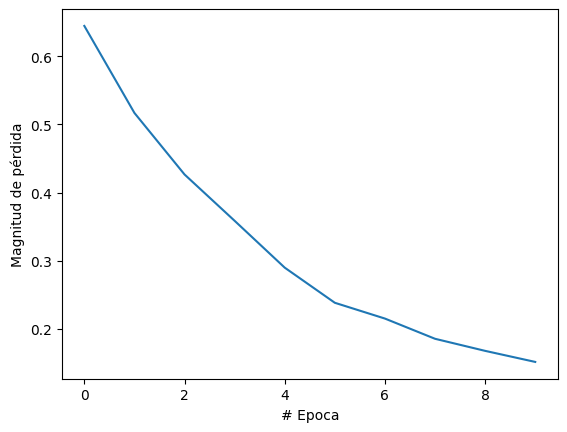

In [12]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(history.history["loss"])

In [13]:
loss, acc = model.evaluate(tsdata)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.7874 - loss: 0.7671
Test Loss: 0.7671
Test Accuracy: 0.7874


In [24]:
checkpoint = ModelCheckpoint(
    "models/best_model.keras",       # formato soportado
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [25]:
history = model.fit(
    trdata,
    validation_data=tsdata,
    epochs=20,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/20
   1/2500 ━━━━━━━━━━━━━━━━━━━━ 9:09 220ms/step - accuracy: 1.0000 - loss: 0.0266

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9491 - loss: 0.1196
Epoch 1: val_accuracy improved from None to 0.78680, saving model to models/best_model.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 286s 115ms/step - accuracy: 0.9488 - loss: 0.1222 - val_accuracy: 0.7868 - val_loss: 1.0197
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9499 - loss: 0.1177
Epoch 2: val_accuracy did not improve from 0.78680
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 277s 111ms/step - accuracy: 0.9506 - loss: 0.1136 - val_accuracy: 0.7852 - val_loss: 0.9883
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9517 - loss: 0.1115
Epoch 3: val_accuracy did not improve from 0.78680
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 332s 115ms/step - accuracy: 0.9536 - loss: 0.1082 - val_accuracy: 0.7798 - val_loss: 1.1627
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9537 - loss: 0.1092
Epoch 4: val_accuracy did not improve from 0.78680
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 288s 

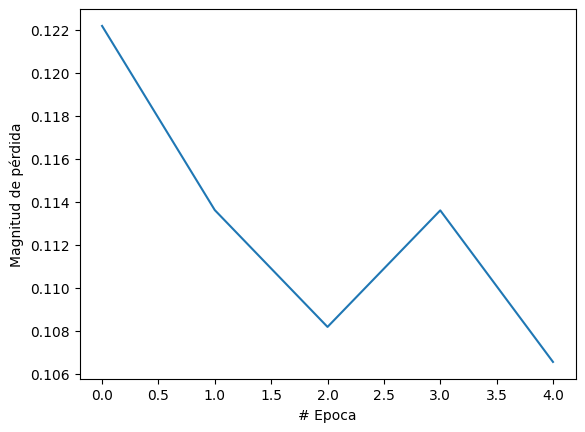

In [26]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(history.history["loss"])

In [30]:
loss, acc = model.evaluate(tsdata)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7852 - loss: 0.9883
Test Loss: 0.9883
Test Accuracy: 0.7852


In [31]:
best_model = load_model("models/best_model.keras")

with open("models/best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)